In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from dolfin import *
from steady_state_adv_diff import *

plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [2]:
def steady_adv_diff_2d(mu, adv, sigma, order, nx, ny, s, method, bc_type):
    # Input
    # mu:     diffusivity, constant
    # adv:    the velocity for advection
    # sigma:  reaction term
    # order:  element order. 1 = linear elements. 2 = quadratic elements.
    # nx:     number of elements in the x direction
    # ny:     number of elements in the y direction
    # s:      the source term. dolfin Expression
    # method: Galerkin, SU, SUPG
    
    # Output
    # u:      the solution, dolfin function
    
    # 2D bilinear mesh
    mesh_2d = RectangleMesh.create([Point(0,0), Point(1,1)], [nx, ny], CellType.Type.quadrilateral)

    hx = 1.0/nx
    hy = 1.0/ny
    
    vel_x = adv*np.cos(np.pi/6)
    vel_y = adv*np.sin(np.pi/6)

    Pe_x = vel_x*hx/(2*mu)
    Pe_y = vel_y*hy/(2*mu)
    
    #print('Peclet number in the x direction = ', Pe_x)
    #print('Peclet number in the y direction = ', Pe_y)

    V = FunctionSpace(mesh_2d, 'CG', order)
    u = TrialFunction(V)
    w = TestFunction(V)

    # Sub domain for inflow 
    class Inflow(SubDomain):
        def inside(self, x, on_boundary):
            return (x[0] < 0.0 + DOLFIN_EPS) and (x[1] > 0.2 - DOLFIN_EPS) and on_boundary

    # Sub domain for outflow
    class Outflow1(SubDomain):
        def inside(self, x, on_boundary):
            return (x[1] < DOLFIN_EPS) and on_boundary
    
    class Outflow2(SubDomain):
        def inside(self, x, on_boundary):
            return (x[0] < 0.0 + DOLFIN_EPS) and (x[1] < 0.2 + DOLFIN_EPS) and on_boundary
        
    class AllBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary
    
    sub_domains = MeshFunction("size_t", mesh_2d, mesh_2d.topology().dim() - 1)
    sub_domains.set_all(0)
    
    if bc_type=='natural':
        Inflow().mark(sub_domains, 1)
        Outflow1().mark(sub_domains, 2)
        Outflow2().mark(sub_domains, 2)
    
    elif bc_type=='essential':
        AllBoundary().mark(sub_domains, 2)
        Inflow().mark(sub_domains, 1)
    
    elif bc_type=='all_zero':
        AllBoundary().mark(sub_domains, 2)
        #Inflow().mark(sub_domains, 1)
        

    bc_in = DirichletBC(V, Constant(1.0), sub_domains, 1)
    bc_out = DirichletBC(V, Constant(0.0), sub_domains, 2)

    bc = [bc_in, bc_out]
    a = as_vector([Constant(vel_x), Constant(vel_y)])
    
    if method=='Galerkin':
        F = w*inner(a, grad(u))*dx \
          + Constant(mu)*inner(grad(w), grad(u))*dx - w*s*dx \
          + Constant(sigma)*w*u*dx
    
    elif method=='SU_anisotropic':
        # Eq. (2.44)
        xi = 1.0/np.tanh(Pe_x) - 1.0/Pe_x
        eta = 1.0/np.tanh(Pe_y) - 1.0/Pe_y

        mu_bar_x = xi*vel_x*hx/2
        mu_bar_y = eta*vel_y*hy/2
        
        # Adding anisotropic diffusion 
        F = w*inner(a, grad(u))*dx \
          + Constant(mu)*inner(grad(w), grad(u))*dx - w*s*dx \
          + Constant(mu_bar_x)/Constant(dot(a,a))*a[0]*w.dx(0)*a[0]*u.dx(0)*dx \
          + Constant(mu_bar_y)/Constant(dot(a,a))*a[1]*w.dx(1)*a[1]*u.dx(1)*dx
    
    elif method=='SU':
        # Eq. (2.44)
        xi = 1.0/np.tanh(Pe_x) - 1.0/Pe_x
        eta = 1.0/np.tanh(Pe_y) - 1.0/Pe_y

        # The artificial diffusion term. Eq. (2.49)
        mu_bar = (xi*vel_x*hx + eta*vel_y*hy)/2
        
        # Adding isotropic diffusion
        F = w*inner(a, grad(u))*dx \
          + Constant(mu)*inner(grad(w), grad(u))*dx - w*s*dx \
          + Constant(mu_bar)/Constant(dot(a,a))*dot(a, grad(w))*dot(a, grad(u))*dx
        
    elif method=='SUPG':
        # Eq. (2.44)
        xi = 1.0/np.tanh(Pe_x) - 1.0/Pe_x
        eta = 1.0/np.tanh(Pe_y) - 1.0/Pe_y

        # The artificial diffusion term. Eq. (2.49)
        mu_bar = (xi*vel_x*hx + eta*vel_y*hy)/2
        
        F = w*inner(a, grad(u))*dx \
          + Constant(mu)*inner(grad(w), grad(u))*dx - w*s*dx \
          + Constant(sigma)*w*u*dx \
          + Constant(mu_bar)/Constant(dot(a,a))*dot(a, grad(w))*dot(a, grad(u) + Constant(sigma)*u - s)*dx
          #+ Constant(mu_bar)*a[0]*w.dx(0)*(a[0]*u.dx(0) - Constant(sigma)*u - s)*dx
    
    a, L = lhs(F), rhs(F)

    u = Function(V)
    solve(a==L, u, bcs=bc)
    
    return u, V.dofmap().dofs(), V.tabulate_dof_coordinates().T #vertex_to_dof_map(V)

In [3]:
nx = 10
ny = 10

u, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1.0, sigma=0.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='Galerkin', bc_type='natural')
u_SU, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1.0, sigma=0.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='SU_anisotropic', bc_type='natural')
u_FU, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1.0, sigma=0.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='SU', bc_type='natural')
coord_x = coord[0]
coord_y = coord[1]

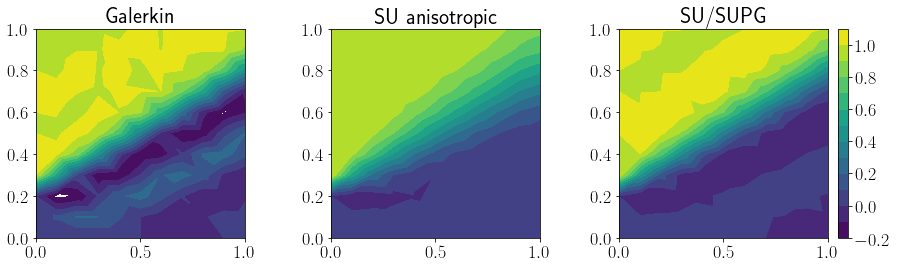

In [4]:
# Reproducing Fig. 2.19, downwind natural boundary conditions.
fig, ax = plt.subplots(1, 3, figsize=(13,4))

cb = ax[0].tricontourf(coord_x, coord_y, u.vector()[:], levels=np.linspace(-0.2, 1.1, 14))
cb = ax[1].tricontourf(coord_x, coord_y, u_SU.vector()[:], levels=np.linspace(-0.2, 1.1, 14))
cb = ax[2].tricontourf(coord_x, coord_y, u_FU.vector()[:], levels=np.linspace(-0.2, 1.1, 14))

ax[0].set_aspect('equal', 'box')
ax[0].set_title('Galerkin')
ax[1].set_aspect('equal', 'box')
ax[1].set_title('SU anisotropic')
ax[2].set_aspect('equal', 'box')
ax[2].set_title('SU/SUPG')

fig.colorbar(cb, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
nx = 10
ny = 10

u, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1.0, sigma=0.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='Galerkin', bc_type='essential')
u_SU, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1.0, sigma=0.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='SU_anisotropic', bc_type='essential')
u_FU, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1.0, sigma=0.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='SU', bc_type='essential')
coord_x = coord[0]
coord_y = coord[1]

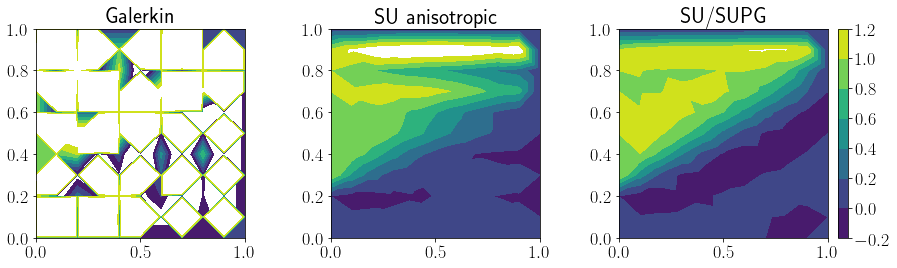

In [6]:
# Reproducing Fig. 2.20, downwind essential boundary conditions.
fig, ax = plt.subplots(1, 3, figsize=(13,4))

cb = ax[0].tricontourf(coord_x, coord_y, u.vector()[:], levels=np.linspace(-0.2, 1.2, 8))
cb = ax[1].tricontourf(coord_x, coord_y, u_SU.vector()[:], levels=np.linspace(-0.2, 1.2, 8))
cb = ax[2].tricontourf(coord_x, coord_y, u_FU.vector()[:], levels=np.linspace(-0.2, 1.2, 8))

ax[0].set_aspect('equal', 'box')
ax[0].set_title('Galerkin')
ax[1].set_aspect('equal', 'box')
ax[1].set_title('SU anisotropic')
ax[2].set_aspect('equal', 'box')
ax[2].set_title('SU/SUPG')

fig.colorbar(cb, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [7]:
nx = 10
ny = 10

u, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=0.5, sigma=1.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='Galerkin', bc_type='essential')
u_SUPG, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=0.5, sigma=1.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='SU', bc_type='essential')
coord_x = coord[0]
coord_y = coord[1]

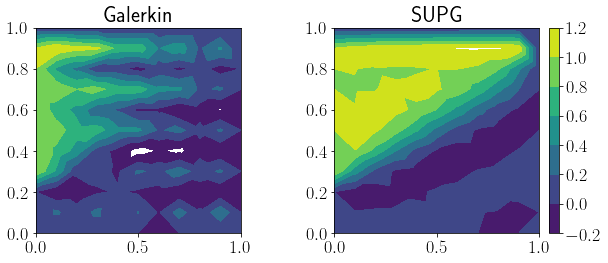

In [8]:
# Reproducing Fig. 2.21
# I can't figure out the boundary conditions precribed in the book.
fig, ax = plt.subplots(1, 2, figsize=(9,4))

cb = ax[0].tricontourf(coord_x, coord_y, u.vector()[:], levels=np.linspace(-0.2, 1.2, 8))
cb = ax[1].tricontourf(coord_x, coord_y, u_SUPG.vector()[:], levels=np.linspace(-0.2, 1.2, 8))

ax[0].set_aspect('equal', 'box')
ax[0].set_title('Galerkin')
ax[1].set_aspect('equal', 'box')
ax[1].set_title('SUPG')

fig.colorbar(cb, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [9]:
nx = 10
ny = 10

u, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1e-3, sigma=1.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='Galerkin', bc_type='essential')
u_SUPG, dof, coord = steady_adv_diff_2d(mu=1e-4, adv=1e-3, sigma=1.0, order=1, nx=nx, ny=ny, s=Expression('0.0', degree=1), method='SU', bc_type='essential')
coord_x = coord[0]
coord_y = coord[1]

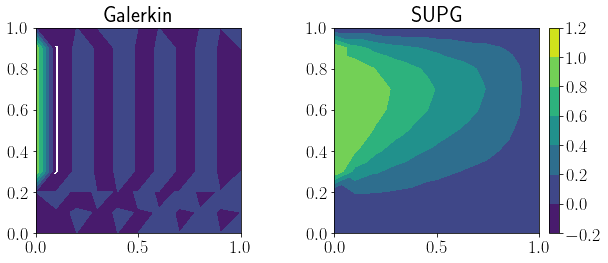

In [10]:
# Reproducing Fig. 2.21
# I can't figure out the boundary conditions precribed in the book.
fig, ax = plt.subplots(1, 2, figsize=(9,4))

cb = ax[0].tricontourf(coord_x, coord_y, u.vector()[:], levels=np.linspace(-0.2, 1.2, 8))
cb = ax[1].tricontourf(coord_x, coord_y, u_SUPG.vector()[:], levels=np.linspace(-0.2, 1.2, 8))

ax[0].set_aspect('equal', 'box')
ax[0].set_title('Galerkin')
ax[1].set_aspect('equal', 'box')
ax[1].set_title('SUPG')

fig.colorbar(cb, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()